In [1]:
import pandas as pd
import numpy as np

In [291]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

In [103]:
pd.set_option('max_columns', None)

In [292]:
# Open listings data
boston_listings = pd.read_csv("boston_airbnb_data/listings.csv")
seattle_listings = pd.read_csv("seattle_airbnb_data/listings.csv")

In [3]:
# Quick explore of number of rows and columns of calendar data
print("Boston calendar data have {} columns and {} rows and Seattle calendar data have {} columns and {} rows".format(str(boston_listings.shape[1]),str(boston_listings.shape[0]),str(seattle_listings.shape[1]),str(seattle_listings.shape[0])))

Boston calendar data have 95 columns and 3585 rows and Seattle calendar data have 92 columns and 3818 rows


###  Compare both data frames to detect differences and be able to take decisions

In [17]:
# Columns and type for boston and seattle listings
boston_col_type = boston_listings.dtypes.to_dict()
seattle_col_type = seattle_listings.dtypes.to_dict()

# Compares columns and columns type to see if they are equivalent or there are differences between them

nonshared_columns = []
nonshared_types = {}

for boston_col, boston_type in boston_col_type.items():
    found_indicator = 0
    for seattle_col, seattle_type in seattle_col_type.items():
        if boston_col == seattle_col and boston_type == seattle_type:
            found_indicator = 1
            break
        elif boston_col == seattle_col and boston_type != seattle_type:
            nonshared_types[boston_col] = {"in_df_boston":boston_type,"in_df_seattle":seattle_type}
            found_indicator = 1
            break
    if found_indicator == 0:
        nonshared_columns.append(boston_col)
    
            

#### Explore non-shared columns

In [18]:
# Show columns that exist in boston df but not in seattle df
nonshared_columns

['access', 'interaction', 'house_rules']

In [29]:
boston_listings[['access', 'interaction', 'house_rules']].describe()

,access,interaction,house_rules
count,2096,2031,2393
unique,1762,1617,1928
top,"You have access to the entire apartment, and a...",Need more towels? A restaurant recommendation?...,House Rules 1. Check-in is 4 pm local time. If...
freq,48,58,44


#### Explore columns don't share dtype

In [30]:
# Show columns that exist in both df but they don't share dtype
nonshared_types

{'host_listings_count': {'in_df_boston': dtype('int64'),
  'in_df_seattle': dtype('float64')},
 'host_total_listings_count': {'in_df_boston': dtype('int64'),
  'in_df_seattle': dtype('float64')},
 'neighbourhood_group_cleansed': {'in_df_boston': dtype('float64'),
  'in_df_seattle': dtype('O')},
 'has_availability': {'in_df_boston': dtype('float64'),
  'in_df_seattle': dtype('O')},
 'jurisdiction_names': {'in_df_boston': dtype('float64'),
  'in_df_seattle': dtype('O')}}

In [27]:
boston_listings[["neighbourhood_group_cleansed","has_availability","jurisdiction_names"]].describe()

,neighbourhood_group_cleansed,has_availability,jurisdiction_names
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


In [28]:
seattle_listings[["neighbourhood_group_cleansed","has_availability","jurisdiction_names"]].describe()

,neighbourhood_group_cleansed,has_availability,jurisdiction_names
count,3818,3818,3818
unique,17,1,1
top,Other neighborhoods,t,WASHINGTON
freq,794,3818,3818


In [44]:
# Drop non-shared columns
udpate_boston_listings = boston_listings.drop( ['access', 'interaction', 'house_rules'], axis=1)

In [59]:
# Gets boston and seattle columns names in a individual list
boston_cols = list(udpate_boston_listings.columns)
seattle_cols = list(seattle_listings.columns)

In [74]:
# Check if indeed both df already have the same number of columns
print("Number of columns in boston df: {} and number of columns in seattle df: {}".format(len(boston_cols),len(seattle_cols)))

Number of columns in boston df: 92 and number of columns in seattle df: 92


In [73]:
# Check columns have the same position in both df
all_same_position = "Yes"
for position in range(len(boston_cols)):
    if boston_cols[position] != seattle_cols[position]:
        all_same_position = "No"

print("¿Columns have the same position in both df? {}".format(all_same_position))

¿Columns have the same position in both df? Yes


After the previous analysis we can conclude that it is useful to concat both dataframes for the following reasons:

1. Dataframes do not share only 3 columns that do not contain useful information for our case
2. Dropping non-shared columns leave us with two dataframes with the same columns in the same position
3. Five columns do no share type, two due to difference in the interpretation between int and float, which is easily solved, and three because boston dataframe only has null values in those columns
4. Concatenating the data from Boston and Seattle gives us a larger sample in which the city becomes another variable to analyze.

### Unified dataframe with both cities: boston and seattle

In [161]:
df_listings = pd.concat([udpate_boston_listings, seattle_listings], axis=0)

In [267]:
df_listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...",https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1.0,1.0,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.286241,-71.134374,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$65.00,$400.00,NaN,$95.00,$10.00,0,$0.00,2,15,a week ago,NaN,26,54,84

In [245]:
# Create a dataframe with the column name and the percent of missing values per column
percent_missing = df_listings.isnull().sum()*100/len(df_listings)

df_nullrows_percent = pd.DataFrame({'column_name': df_listings.columns,
                                 'percent_missing': percent_missing}).reset_index(drop=True)

In [280]:
# Number of columns per range of percent missing values
df_nullrows_percent["percent_missing"].value_counts(bins=10, sort=False)

(-0.101, 10.0]    61
(10.0, 20.0]      16
(20.0, 30.0]       4
(30.0, 40.0]       2
(40.0, 50.0]       4
(50.0, 60.0]       1
(60.0, 70.0]       2
(70.0, 80.0]       0
(80.0, 90.0]       0
(90.0, 100.0]      2
Name: percent_missing, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0B9D32F0>]],
      dtype=object)

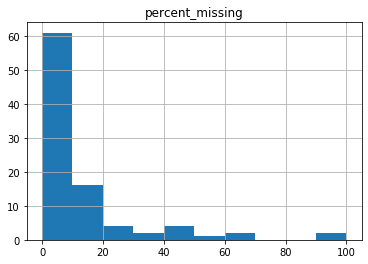

In [283]:
# Histogram of percent missing values
df_nullrows_percent.hist()

We can see that 15 columns out of 92 (16.3%) have more than 20% of rows with null values.

In [284]:
morethan20_cols = df_nullrows_percent[df_nullrows_percent['percent_missing'] > 20 ]

In [285]:
morethan20_cols

,column_name,percent_missing
6,space,21.964069
9,neighborhood_overview,33.054167
10,notes,48.372282
11,transit,30.041875
21,host_about,29.285425
37,neighbourhood_group_cleansed,48.426314
56,square_feet,97.933270
58,weekly_price,60.813184
59,monthly_price,67.513170
60,security_deposit,56.666216


If we keep these columns we will lose a large part of the sample and analyzing them individually we can see that they are not critical for our analysis so they will be eliminated

In [286]:
morethan10_lessthan20_cols = df_nullrows_percent[(df_nullrows_percent['percent_missing'] > 10) & (df_nullrows_percent['percent_missing'] < 20 )]

In [287]:
morethan10_lessthan20_cols

,column_name,percent_missing
12,thumbnail_url,12.413886
13,medium_url,12.413886
15,xl_picture_url,12.413886
22,host_response_time,13.426989
23,host_response_rate,13.426989
24,host_acceptance_rate,16.803998
35,neighbourhood,12.954208
74,first_review,18.681616
75,last_review,18.681616
76,review_scores_rating,19.721734


If we keep some of these columns we will lose a large part of the sample, especially the review scores that are of interest for the analysis.

In [293]:
df_listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...",https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1.0,1.0,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.286241,-71.134374,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$65.00,$400.00,NaN,$95.00,$10.00,0,$0.00,2,15,a week ago,NaN,26,54,84

In [ ]:
columns_of_interest = ['id','name','experiences_offered','host_id','host_name','host_since','host_location',
                       'host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost',
                       'host_listings_count','host_total_listings_count','host_verifications','host_has_profile_pic',
                       'host_identity_verified','zipcode','smart_location','latitude','longitude','is_location_exact',
                       'property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities',
                       'price','guests_included','extra_people','minimum_nights','maximum_nights',
                       'calendar_updated','number_of_reviews','review_scores_rating','review_scores_cleanliness',
                       'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value',
                       'requires_license','instant_bookable','cancellation_policy','require_guest_profile_picture',
                       'require_guest_phone_verification','calculated_host_listings_count','reviews_per_month']